# 🤖 House Price Prediction - Model Training

This notebook trains the multimodal house price prediction model:
1. Load preprocessed data
2. Prepare features (tabular + images)
3. Automatic PCA selection for image embeddings
4. Train tabular-only and multimodal XGBoost models
5. Evaluate and visualize results

**By:**Anshit Das


## 📚 Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## ⚙️ Configuration

In [63]:
# Paths
DATA_PATH = "/kaggle/working/processed_data.csv"  # Update with your path
MODEL_SAVE_PATH = "models/multimodal_predictor.pkl"

# Training settings
RANDOM_STATE = 4508976
TEST_SIZE = 0.2
PCA_ELBOW_THRESHOLD = 0.005

# XGBoost hyperparameters
XGB_PARAMS = {
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 2.0,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'random_state': RANDOM_STATE,
    'verbosity': 0
}

print("Configuration loaded")

Configuration loaded


## 📊 Load Preprocessed Data

In [35]:
# Load data
df = pd.read_csv(DATA_PATH)

print(f"📊 Loaded {len(df)} rows")
print(f"Shape: {df.shape}")

# Display first few rows
df.head()

📊 Loaded 16110 rows
Shape: (16110, 2096)


id        date   price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  9117000170  2015-05-05  268643         4       2.25         1810      9240   
1  6700390210  2014-07-08  245000         3       2.50         1600      2788   
2  7212660540  2015-01-15  200000         4       2.50         1720      8638   
3  8562780200  2015-04-27  352499         2       2.25         1240       705   
4  7760400350  2014-12-05  232000         3       2.00         1280     13356   

   floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0     2.0           0     0          3      7        1810              0   
1     2.0           0     0          4      7        1600              0   
2     2.0           0     0          3      8        1720              0   
3     2.0           0     0          3      7        1150             90   
4     1.0           0     0          3      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  log_price  bath_per_bed  sqft_per_bed  lot_to_living_ratio  \
0        9240  12.501142      0.562359    452.386903             5.104972   
1        3605  12.409018      0.833056    533.155615             1.742500   
2        7455  12.206078      0.624844    429.892527             5.022093   
3         750  12.772806      1.124438    619.690155             0.568548   
4        8071  12.354497      0.666445    426.524492            10.434375   

   basement_ratio  house_age  renovated  years_since_reno  quality_area  \
0        0.000000         54          0                54         12670   
1        0.000000         23          0                23         11200   
2        0.000000         21          0                21         13760   
3        0.072581          6          0                 6          8680   
4        0.000000         21          0                21          8960   

   condition_area  view_score  waterfront_premium  relative_living_size  \
0            5430         0.0                   0              1.090361   
1            6400         0.0                   0              0.930233   
2            5160         0.0                   0              0.919786   
3            3720         0.0                   0              1.000000   
4            3840         0.0                   0              0.805031   

   relative_lot_size     img_0     img_1     img_2     img_3     img_4  \
0           1.000000  0.143885  0.147370  0.313415  0.813622  0.377793   
1           0.773370  0.283116  0.342108  0.162238  0.732684  0.151334   
2           1.158685  0.186955  0.340526  0.097631  0.689624  0.263281   
3           0.940000  0.071168  0.328115  0.226939  0.556342  0.206303   
4           1.654814  0.231751  0.453896  0.300034  0.622077  0.216284   

      img_5     img_6     img_7     img_8     img_9    img_10    img_11  \
0  0.363498  0.188995  0.411102  0.178110  0.487855  0.350154  0.272767   
1  0.462343  0.258736  0.416358  0.252730  0.798671  0.275738  0.358678   
2  0.691801  0.164175  0.235553  0.424124  0.382922  0.386216  0.446465   
3  0.288554  0.335695  0.318675  0.169599  0.755738  0.315487  0.286962   
4  0.413376  0.166728  0.177878  0.258080  0.586735  0.462383  0.494058   

     img_12    img_13    img_14    img_15    img_16    img_17    img_18  \
0  0.532761  0.225165  0.315736  0.143520  0.918613  0.263920  0.671585   
1  0.533511  0.462218  0.313854  0.116420  0.703846  0.265605  0.772776   
2  1.029566  0.299239  0.613711  0.233583  0.920810  0.347650  0.345143   
3  0.314866  0.165605  0.703387  0.319631  0.329757  0.172153  0.455208   
4  0

## 🔧 Prepare Features

In [37]:
# Identify feature columns
IMG_COLS = [c for c in df.columns if c.startswith("img_")]
DROP_COLS = ["id", "date", "price", "log_price", "zipcode"]

TABULAR_COLS = [
    c for c in df.columns
    if c not in DROP_COLS and not c.startswith("img_")
]

print(f"✔ Tabular features: {len(TABULAR_COLS)}")
print(f"✔ Image embedding features: {len(IMG_COLS)}")

# Display feature list
print(f"\nTabular features:")
print(TABULAR_COLS[:10], "...")

✔ Tabular features: 43
✔ Image embedding features: 2048

Tabular features:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above'] ...


## 🎯 Train/Test Split

In [38]:
# Split data
train_df, test_df = train_test_split(
    df, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

train_df = train_df.copy()
test_df = test_df.copy()

print(f"✔ Train size: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"✔ Test size:  {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")

✔ Train size: 12,888 (80.0%)
✔ Test size:  3,222 (20.0%)


## 🏷️ Target Encoding for Zipcode (Leak-Free)

In [39]:
# Calculate zipcode means from training data only
global_mean = train_df["log_price"].mean()
zipcode_mean = train_df.groupby("zipcode")["log_price"].mean()

# Apply to train and test
train_df["zipcode_te"] = train_df["zipcode"].map(zipcode_mean).fillna(global_mean)
test_df["zipcode_te"] = test_df["zipcode"].map(zipcode_mean).fillna(global_mean)

# Add to feature list
TAB_FEATURES = TABULAR_COLS + ["zipcode_te"]

print(f"✓ Zipcode target-encoded (leak-free)")
print(f"Total tabular features: {len(TAB_FEATURES)}")

✓ Zipcode target-encoded (leak-free)
Total tabular features: 44


## 📊 Extract Targets

In [40]:
# Extract target values
y_train_log = train_df["log_price"].values
y_test_log = test_df["log_price"].values

y_train_price = np.expm1(y_train_log)
y_test_price = np.expm1(y_test_log)

print(f"✓ Targets extracted")
print(f"\nTrain price range: ${y_train_price.min():,.0f} - ${y_train_price.max():,.0f}")
print(f"Test price range:  ${y_test_price.min():,.0f} - ${y_test_price.max():,.0f}")

✓ Targets extracted

Train price range: $80,000 - $7,700,000
Test price range:  $75,000 - $4,668,000


## 🔍 PCA Selection with Elbow Detection

In [64]:
print("🔍 Fitting PCA on training image embeddings...\n")

# Fit PCA on all components
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(train_df[IMG_COLS].values)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

print(f"✓ PCA fitted on {len(IMG_COLS)} dimensions")
print(f"Variance explained by first 10 components: {cum_var[9]:.3f}")
print(f"Variance explained by first 50 components: {cum_var[49]:.3f}")
print(f"Variance explained by first 100 components: {cum_var[99]:.3f}")

🔍 Fitting PCA on training image embeddings...

✓ PCA fitted on 2048 dimensions
Variance explained by first 10 components: 0.640
Variance explained by first 50 components: 0.853
Variance explained by first 100 components: 0.918


In [65]:
# Find elbow point
def find_elbow(cum_var, threshold=0.005):
    """Find elbow point in cumulative variance explained."""
    diffs = np.diff(cum_var)
    for i in range(1, len(diffs)):
        if diffs[i] < threshold:
            return i + 1
    return len(cum_var)

elbow_k = find_elbow(cum_var, PCA_ELBOW_THRESHOLD)

print(f"\n📌 Elbow detected at PCA components = {elbow_k}")
print(f"Variance explained at elbow: {cum_var[elbow_k-1]:.3f}")


📌 Elbow detected at PCA components = 26
Variance explained at elbow: 0.776


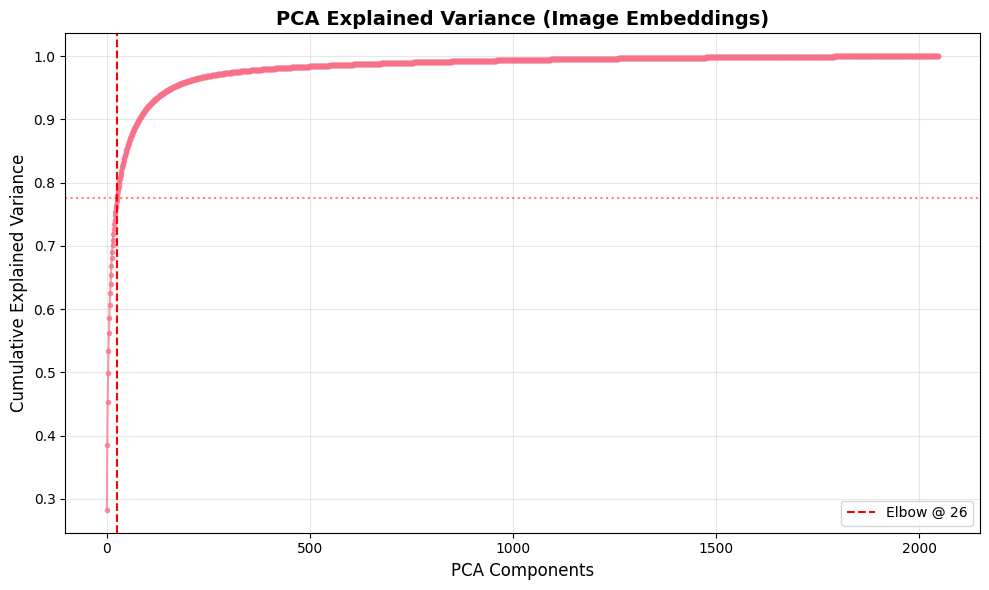

📊 Plot saved to pca_variance.png


In [66]:
# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(cum_var, marker=".", alpha=0.7)
plt.axvline(elbow_k, color="red", linestyle="--", label=f"Elbow @ {elbow_k}")
plt.axhline(cum_var[elbow_k-1], color="red", linestyle=":", alpha=0.5)
plt.xlabel("PCA Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("PCA Explained Variance (Image Embeddings)", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pca_variance.png", dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved to pca_variance.png")

In [67]:
# Generate PCA candidates around elbow
candidate_pcas = sorted(set([
    int(elbow_k * 0.5),
    int(elbow_k * 0.75),
    elbow_k,
    int(elbow_k * 1.25),
    int(elbow_k * 1.5)
]))

candidate_pcas = [k for k in candidate_pcas if k > 10]

print(f"\n▶ PCA candidates to evaluate: {candidate_pcas}")


▶ PCA candidates to evaluate: [13, 19, 26, 32, 39]


## 🎯 Evaluate PCA Candidates

In [68]:
print("\n🎯 Evaluating PCA sizes using validation R²...\n")

best_r2 = -np.inf
best_k = None
r2_history = {}

for k in tqdm(candidate_pcas, desc="Evaluating PCA sizes"):
    # Apply PCA
    pca = PCA(n_components=k, random_state=RANDOM_STATE)
    
    train_emb = pca.fit_transform(train_df[IMG_COLS].values)
    test_emb = pca.transform(test_df[IMG_COLS].values)
    
    # Prepare features
    Xtr = train_df[TAB_FEATURES].copy()
    Xte = test_df[TAB_FEATURES].copy()
    
    for i in range(k):
        Xtr[f"img_pca_{i}"] = train_emb[:, i]
        Xte[f"img_pca_{i}"] = test_emb[:, i]
    
    # Train model
    model = XGBRegressor(**XGB_PARAMS)
    model.fit(Xtr, y_train_log)
    
    # Evaluate
    pred_log = model.predict(Xte)
    pred_price = np.expm1(pred_log)
    
    r2 = r2_score(y_test_price, pred_price)
    r2_history[k] = r2
    
    if r2 > best_r2:
        best_r2 = r2
        best_k = k

print(f"\n🏆 BEST PCA COMPONENTS: {best_k}")
print(f"🏆 BEST VALIDATION R²: {best_r2:.4f}")


🎯 Evaluating PCA sizes using validation R²...



Evaluating PCA sizes: 100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


🏆 BEST PCA COMPONENTS: 26
🏆 BEST VALIDATION R²: 0.9131


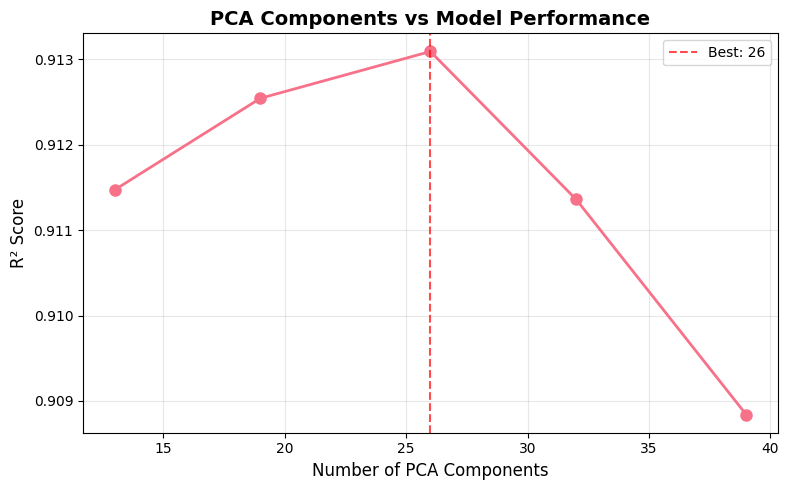

In [69]:
# Plot R² vs PCA components
plt.figure(figsize=(8, 5))
plt.plot(list(r2_history.keys()), list(r2_history.values()), 
         marker='o', linewidth=2, markersize=8)
plt.axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Best: {best_k}')
plt.xlabel('Number of PCA Components', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('PCA Components vs Model Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🤖 Train Final Models

### Model 1: Tabular Only

In [70]:
print("\n🤖 Training TABULAR-ONLY model...")

# Train
model_tab = XGBRegressor(**XGB_PARAMS)
model_tab.fit(train_df[TAB_FEATURES], y_train_log)

# Predict
pred_tab_log = model_tab.predict(test_df[TAB_FEATURES])
pred_tab_price = np.expm1(pred_tab_log)

# Evaluate
rmse_tab = np.sqrt(mean_squared_error(y_test_price, pred_tab_price))
mae_tab = mean_absolute_error(y_test_price, pred_tab_price)
r2_tab = r2_score(y_test_price, pred_tab_price)

print(f"\n✅ TABULAR-ONLY MODEL:")
print(f"   RMSE: ${rmse_tab:,.2f}")
print(f"   MAE:  ${mae_tab:,.2f}")
print(f"   R²:   {r2_tab:.4f}")


🤖 Training TABULAR-ONLY model...

✅ TABULAR-ONLY MODEL:
   RMSE: $103,753.43
   MAE:  $62,376.39
   R²:   0.9119


### Model 2: Multimodal (Tabular + Images)

In [71]:
print(f"\n🤖 Training MULTIMODAL model with {best_k} PCA components...")

# Apply optimal PCA
pca = PCA(n_components=best_k, random_state=RANDOM_STATE)

train_emb = pca.fit_transform(train_df[IMG_COLS].values)
test_emb = pca.transform(test_df[IMG_COLS].values)

# Prepare features
Xtr_full = train_df[TAB_FEATURES].copy()
Xte_full = test_df[TAB_FEATURES].copy()

for i in range(best_k):
    Xtr_full[f"img_pca_{i}"] = train_emb[:, i]
    Xte_full[f"img_pca_{i}"] = test_emb[:, i]

print(f"✓ Feature matrix shape: {Xtr_full.shape}")

# Train
model_full = XGBRegressor(**XGB_PARAMS)
model_full.fit(Xtr_full, y_train_log)

# Predict
pred_full_log = model_full.predict(Xte_full)
pred_full_price = np.expm1(pred_full_log)

# Evaluate
rmse_full = np.sqrt(mean_squared_error(y_test_price, pred_full_price))
mae_full = mean_absolute_error(y_test_price, pred_full_price)
r2_full = r2_score(y_test_price, pred_full_price)

print(f"\n✅ MULTIMODAL MODEL:")
print(f"   RMSE: ${rmse_full:,.2f}")
print(f"   MAE:  ${mae_full:,.2f}")
print(f"   R²:   {r2_full:.4f}")


🤖 Training MULTIMODAL model with 26 PCA components...
✓ Feature matrix shape: (12888, 70)

✅ MULTIMODAL MODEL:
   RMSE: $103,070.82
   MAE:  $62,218.05
   R²:   0.9131


## 📊 Final Results Comparison

In [72]:
# Print comparison
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

print("\nTABULAR ONLY MODEL:")
print(f"  RMSE: ${rmse_tab:,.2f}")
print(f"  MAE:  ${mae_tab:,.2f}")
print(f"  R²:   {r2_tab:.4f}")

print("\nMULTIMODAL MODEL (Tabular + Images):")
print(f"  PCA components: {best_k}")
print(f"  RMSE: ${rmse_full:,.2f}")
print(f"  MAE:  ${mae_full:,.2f}")
print(f"  R²:   {r2_full:.4f}")

improvement_rmse = ((rmse_tab - rmse_full) / rmse_tab) * 100
improvement_r2 = ((r2_full - r2_tab) / r2_tab) * 100

print("\n📈 IMPROVEMENT:")
print(f"  RMSE: {improvement_rmse:+.2f}%")
print(f"  R²:   {improvement_r2:+.2f}%")
print("="*60)


FINAL RESULTS

TABULAR ONLY MODEL:
  RMSE: $103,753.43
  MAE:  $62,376.39
  R²:   0.9119

MULTIMODAL MODEL (Tabular + Images):
  PCA components: 26
  RMSE: $103,070.82
  MAE:  $62,218.05
  R²:   0.9131

📈 IMPROVEMENT:
  RMSE: +0.66%
  R²:   +0.13%


In [73]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Tabular Only', 'Multimodal'],
    'RMSE': [rmse_tab, rmse_full],
    'MAE': [mae_tab, mae_full],
    'R²': [r2_tab, r2_full]
})

results_df

,Model,RMSE,MAE,R²
0,Tabular Only,103753.426937,62376.385514,0.911939
1,Multimodal,103070.823194,62218.054654,0.913093


## 📊 Visualize Predictions

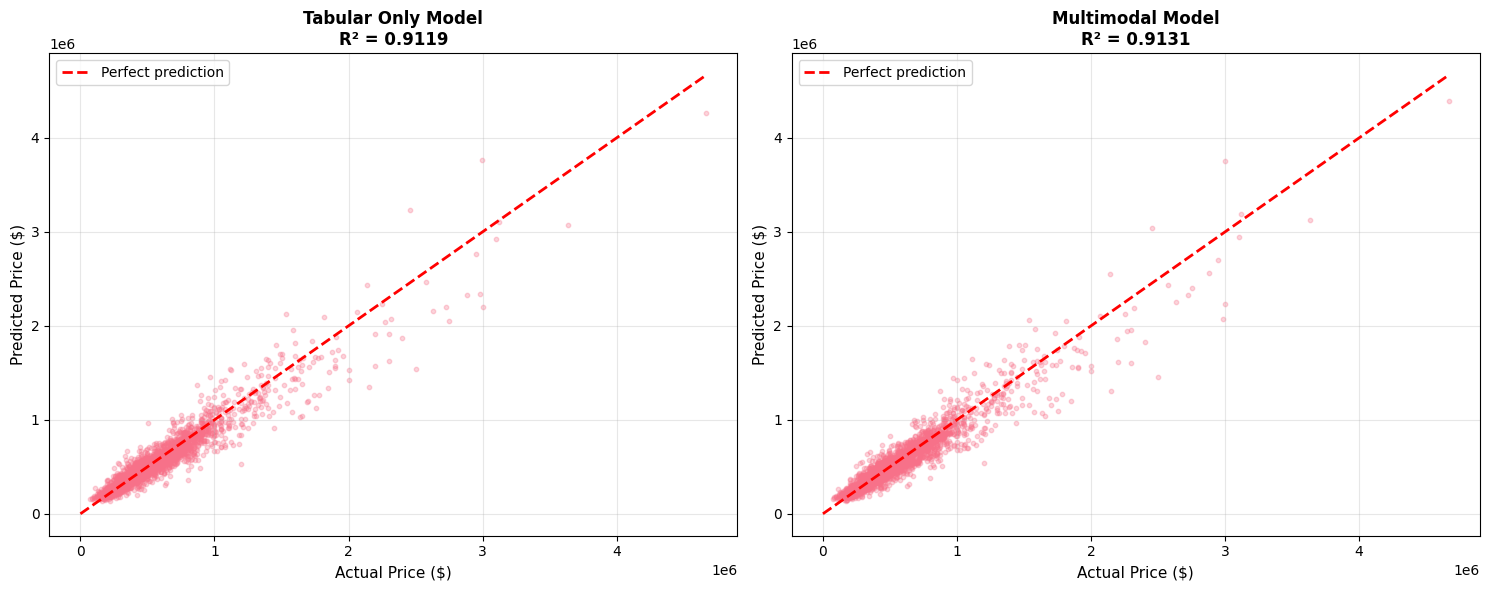

📊 Plot saved to predictions.png


In [74]:
# Predicted vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tabular only
axes[0].scatter(y_test_price, pred_tab_price, alpha=0.3, s=10)
axes[0].plot([0, y_test_price.max()], [0, y_test_price.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=11)
axes[0].set_ylabel('Predicted Price ($)', fontsize=11)
axes[0].set_title(f'Tabular Only Model\nR² = {r2_tab:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Multimodal
axes[1].scatter(y_test_price, pred_full_price, alpha=0.3, s=10)
axes[1].plot([0, y_test_price.max()], [0, y_test_price.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=11)
axes[1].set_ylabel('Predicted Price ($)', fontsize=11)
axes[1].set_title(f'Multimodal Model\nR² = {r2_full:.4f}', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved to predictions.png")

## 🔍 Feature Importance Analysis

In [75]:
# Extract feature importance
importance = model_full.feature_importances_
feature_names = Xte_full.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
})

# Remove zero-importance features
fi_df = fi_df[fi_df["importance"] > 0]

# Sort by importance
fi_df = fi_df.sort_values("importance", ascending=False)

# Add feature group
fi_df["feature_group"] = fi_df["feature"].apply(
    lambda x: "Image (PCA)" if x.startswith("img_pca_") else "Tabular"
)

print(f"Total features with non-zero importance: {len(fi_df)}")
print(f"\nTop 10 features:")
fi_df.head(10)

Total features with non-zero importance: 70

Top 10 features:


,feature,importance,feature_group
43,zipcode_te,0.246593,Tabular
24,quality_area,0.232158,Tabular
8,grade,0.114607,Tabular
2,sqft_living,0.055426,Tabular
13,lat,0.050230,Tabular
25,condition_area,0.034942,Tabular
26,view_score,0.024501,Tabular
6,view,0.021384,Tabular
14,long,0.017064,Tabular
5,waterfront,0.016516,Tabular


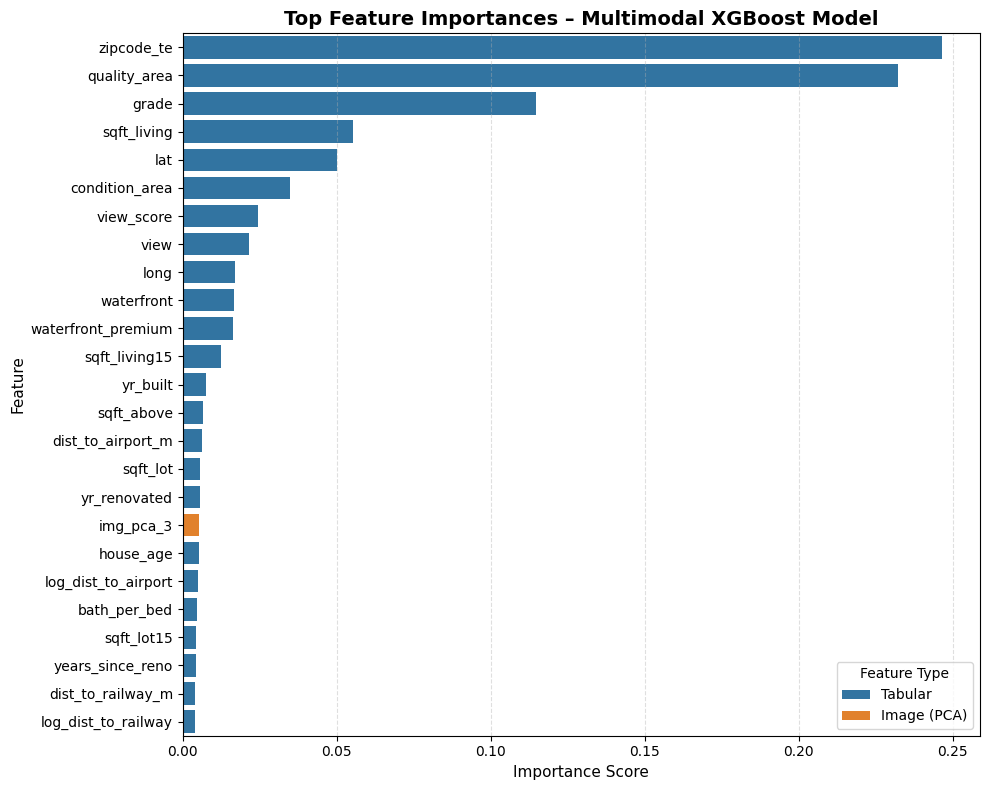

📊 Plot saved to feature_importance.png


In [76]:
# Plot feature importance
TOP_N = 25

plt.figure(figsize=(10, 8))
sns.barplot(
    data=fi_df.head(TOP_N),
    x="importance",
    y="feature",
    hue="feature_group",
    dodge=False,
    palette={"Tabular": "#1f77b4", "Image (PCA)": "#ff7f0e"}
)

plt.title("Top Feature Importances – Multimodal XGBoost Model", 
          fontsize=14, fontweight='bold')
plt.xlabel("Importance Score", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.legend(title="Feature Type", fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved to feature_importance.png")

In [77]:
# Feature importance by group
group_importance = fi_df.groupby('feature_group')['importance'].sum()

print("\nFeature importance by group:")
for group, imp in group_importance.items():
    pct = (imp / fi_df['importance'].sum()) * 100
    print(f"  {group}: {pct:.1f}%")


Feature importance by group:
  Image (PCA): 4.8%
  Tabular: 95.2%


## 💾 Save Model

In [78]:
# Prepare model package
model_data = {
    'model_tabular': model_tab,
    'model_multimodal': model_full,
    'pca': pca,
    'best_n_components': best_k,
    'global_mean': global_mean,
    'zipcode_mean': zipcode_mean,
    'xgb_params': XGB_PARAMS,
    'results': {
        'tabular_only': {
            'rmse': rmse_tab,
            'mae': mae_tab,
            'r2': r2_tab
        },
        'multimodal': {
            'rmse': rmse_full,
            'mae': mae_full,
            'r2': r2_full
        }
    }
}

# Save
import os
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"💾 Model saved to: {MODEL_SAVE_PATH}")
print(f"📦 Package size: {os.path.getsize(MODEL_SAVE_PATH) / 1024**2:.2f} MB")

💾 Model saved to: models/multimodal_predictor.pkl
📦 Package size: 2.97 MB


## 📊 Residual Analysis

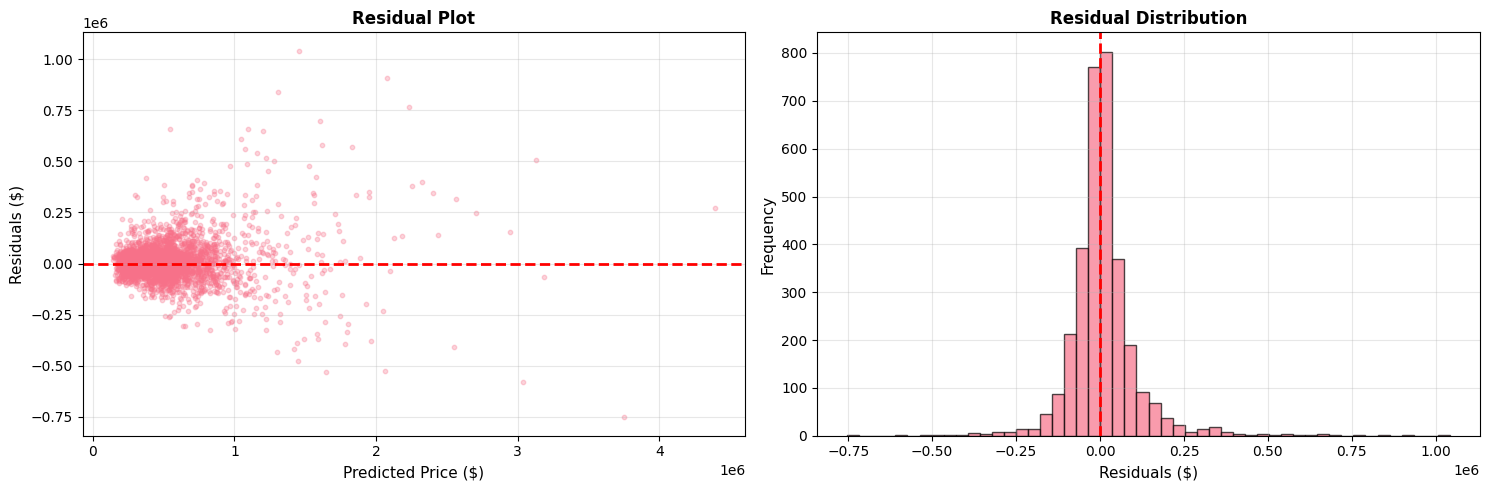

📊 Plot saved to residuals.png


In [79]:
# Calculate residuals
residuals = y_test_price - pred_full_price

# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual plot
axes[0].scatter(pred_full_price, residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Price ($)', fontsize=11)
axes[0].set_ylabel('Residuals ($)', fontsize=11)
axes[0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals ($)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residuals.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Plot saved to residuals.png")

## ✅ Training Complete!

### Summary:
- ✓ Trained tabular-only baseline model
- ✓ Optimized PCA dimensionality with elbow detection
- ✓ Trained multimodal model (tabular + images)
- 
### Next Steps:
1. Use `inference.py` to make predictions on new data
2. Run `visualizations.py` for Grad-CAM analysis
